In [1]:
import math

import numpy as np

from keras import applications
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Only for MacOS
Tensorflow GPU won't support for macOS versions of 12.0 and higher

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
img_width, img_height = 120, 80

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '../CorelDBDataSet/train'
validation_data_dir = '../CorelDBDataSet/val'

epochs = 50

batch_size = 16

In [4]:
model = applications.VGG16(include_top=False, weights='imagenet')

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = model.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)

Found 299 images belonging to 5 classes.


In [6]:
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

nb_validation_samples = len(generator.filenames)

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_valdiation = model.predict_generator(generator, predict_size_validation)

np.save('bottleneck_features_validation.npy', bottleneck_features_valdiation)

Found 238 images belonging to 5 classes.


In [7]:
datagen_top = ImageDataGenerator(rescale=1./255)
generator_top = datagen_top.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

train_data = np.load('bottleneck_features_train.npy')

train_labels = generator_top.classes

train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 299 images belonging to 5 classes.


In [8]:
generator_top = datagen_top.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

nb_validation_samples = len(generator_top.filenames)

validation_data = np.load('bottleneck_features_validation.npy')

validation_labels = generator_top.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 238 images belonging to 5 classes.


In [9]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_data, validation_labels)
)

model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate(
    validation_data,
    validation_labels,
    batch_size=batch_size,
    verbose=1
)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] loss: {}".format(eval_loss))

Train on 299 samples, validate on 238 samples
Epoch 1/50
299/299 [==============================] - 1s 3ms/step - loss: 1.0610 - accuracy: 0.5686 - val_loss: 0.5507 - val_accuracy: 0.8109
Epoch 2/50
299/299 [==============================] - 0s 588us/step - loss: 0.5259 - accuracy: 0.8027 - val_loss: 0.3587 - val_accuracy: 0.8529
Epoch 3/50
299/299 [==============================] - 0s 590us/step - loss: 0.2641 - accuracy: 0.8930 - val_loss: 0.2609 - val_accuracy: 0.9034

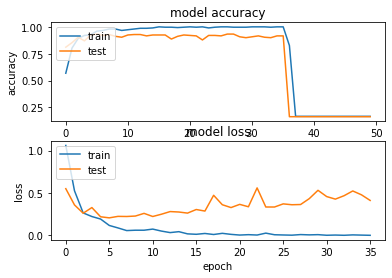

In [10]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()